In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

from sklearn.model_selection import train_test_split

import xgboost as xgb
import shap

In [3]:
RANDOM_STATE = 42

data = pd.read_excel('../data/fraud.xlsx')
# Data Cleaning Steps
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], errors='coerce')
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')
data['is_fraud'] = data['is_fraud'].astype(str).str.replace('1"2020-12-24 16:56:24"', '1')
data['is_fraud'] = data['is_fraud'].str.replace('0"2019-01-01 00:00:44"', '0')
data['is_fraud'] = data['is_fraud'].astype(int)
data['merchant'] = data['merchant'].str.replace(r'^"|"$', '', regex=True)
data['job'] = data['job'].str.replace(r'^"|"$', '', regex=True)
data = data.drop_duplicates(subset='trans_num', keep='first')
data = data.sort_values(by='trans_date_trans_time')
data['merchant'] = data['merchant'].astype('category')
data['category'] = data['category'].astype('category')
data['city'] = data['city'].astype('category')
data['state'] = data['state'].astype('category')
data['job'] = data['job'].astype('category')
data['is_fraud'] = data['is_fraud'].astype('category')
data['trans_num'] = data['trans_num'].astype('category')

In [19]:
X = data.drop(columns=['trans_num'])
y = data['is_fraud']

X['trans_year'] = X['trans_date_trans_time'].dt.year.astype('category')
X['trans_month'] = X['trans_date_trans_time'].dt.month.astype('category')
X['trans_day_of_month'] = X['trans_date_trans_time'].dt.day.astype('category')
X['trans_day_of_week'] = X['trans_date_trans_time'].dt.day_of_week.astype('category')
X['trans_day_of_year'] = X['trans_date_trans_time'].dt.day_of_year.astype('category')
X['trans_hour'] = X['trans_date_trans_time'].dt.hour.astype('category')
X['trans_time_to_second'] = (
    X['trans_date_trans_time'].dt.hour*3600 + 
    X['trans_date_trans_time'].dt.minute*60 + 
    X['trans_date_trans_time'].dt.second
)
X['cust_age'] = (X['trans_date_trans_time'] - data['dob']).dt.days // 365
X['trans_time_sin'] = np.sin(2 * np.pi * X['trans_time_to_second'] / 86400)
X['trans_time_cos'] = np.cos(2 * np.pi * X['trans_time_to_second'] / 86400)
X['distance'] = X.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).meters, axis=1)

X.drop(columns=['merch_lat', 'merch_long', 'lat', 'long', 'trans_date_trans_time', 'dob', 'is_fraud'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

full_DM = xgb.DMatrix(X, label=y, enable_categorical=True)
train_DM = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
test_DM = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [20]:
params = {
    'objective': 'binary:logistic',
    'seed': RANDOM_STATE,
    'eval_metric': 'aucpr',
}

score = xgb.cv(params, full_DM, nfold=5, num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)


[0]	train-aucpr:0.99477+0.00143	test-aucpr:0.98854+0.00593
[10]	train-aucpr:0.99999+0.00000	test-aucpr:0.99841+0.00140
[20]	train-aucpr:1.00000+0.00000	test-aucpr:0.99898+0.00096
[30]	train-aucpr:1.00000+0.00000	test-aucpr:0.99950+0.00047
[40]	train-aucpr:1.00000+0.00000	test-aucpr:0.99961+0.00041
[50]	train-aucpr:1.00000+0.00000	test-aucpr:0.99966+0.00035
[60]	train-aucpr:1.00000+0.00000	test-aucpr:0.99967+0.00033
[70]	train-aucpr:1.00000+0.00000	test-aucpr:0.99967+0.00035
[75]	train-aucpr:1.00000+0.00000	test-aucpr:0.99967+0.00035


In [21]:
bst = xgb.train(params, train_DM, num_boost_round=1000, evals=[(test_DM, 'test')], early_stopping_rounds=10)

[0]	test-aucpr:0.98625
[1]	test-aucpr:0.98809
[2]	test-aucpr:0.98804
[3]	test-aucpr:0.99164
[4]	test-aucpr:0.99363
[5]	test-aucpr:0.99587
[6]	test-aucpr:0.99651
[7]	test-aucpr:0.99649
[8]	test-aucpr:0.99647
[9]	test-aucpr:0.99828
[10]	test-aucpr:0.99837
[11]	test-aucpr:0.99888
[12]	test-aucpr:0.99900
[13]	test-aucpr:0.99905
[14]	test-aucpr:0.99910
[15]	test-aucpr:0.99925
[16]	test-aucpr:0.99924
[17]	test-aucpr:0.99923
[18]	test-aucpr:0.99933
[19]	test-aucpr:0.99943
[20]	test-aucpr:0.99950
[21]	test-aucpr:0.99958
[22]	test-aucpr:0.99962
[23]	test-aucpr:0.99964
[24]	test-aucpr:0.99965
[25]	test-aucpr:0.99971
[26]	test-aucpr:0.99970
[27]	test-aucpr:0.99971
[28]	test-aucpr:0.99978
[29]	test-aucpr:0.99979
[30]	test-aucpr:0.99982
[31]	test-aucpr:0.99984
[32]	test-aucpr:0.99986
[33]	test-aucpr:0.99986
[34]	test-aucpr:0.99988
[35]	test-aucpr:0.99988
[36]	test-aucpr:0.99990
[37]	test-aucpr:0.99991
[38]	test-aucpr:0.99991
[39]	test-aucpr:0.99990
[40]	test-aucpr:0.99988
[41]	test-aucpr:0.99988
[4

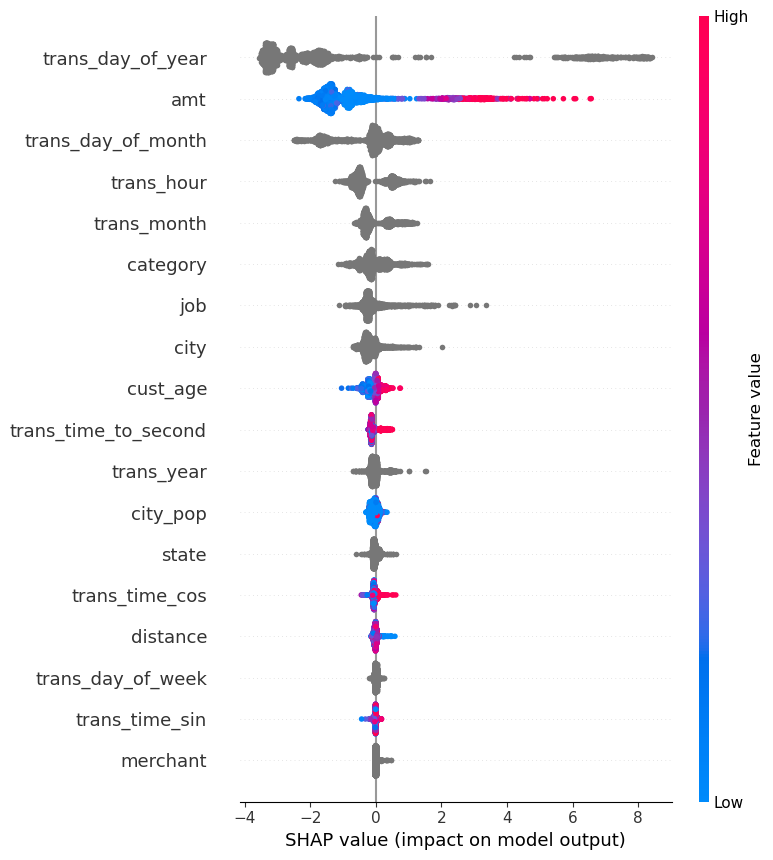

In [22]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_DM)

shap.summary_plot(shap_values, X_test)